<a href="https://colab.research.google.com/github/ramanathanlab/SciFM24-Tutorial/blob/main/notebooks/VirtualScreen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predicting binding affinity using Transformers

Identification of compounds that bind to a target with high affinity constitutes the first step of a drug discovery pipeline.
To streamline this process, highly-scalable computational screening methods are needed to screen chemical space to identify promising candidates.

Here, we demonstrate Simple SMILES Transformer (SST), to approximate the computationally-intensive molecular docking process using an encoder-only Transformer architecture.

## Installing modules and dataloading

Here, we are going to install pandas, tensorflow, transformers, and the SmilesPE tokenizer using pip.

We are also going to git clone a repo with a few additional functions for loading model architecture and tokenizer.

In [1]:
!pip install pandas
!pip install tensorflow==2.12.0
!pip install transformers
!pip install SmilesPE

In [1]:
! git clone https://github.com/architvasan/VirtualScreenTransformers.git

Cloning into 'VirtualScreenTransformers'...
remote: Enumerating objects: 54, done.
remote: Counting objects: 100% (29/29), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 54 (delta 11), reused 19 (delta 4), pack-reused 25
Receiving objects: 100% (54/54), 110.43 MiB | 21.12 MiB/s, done.
Resolving deltas: 100% (17/17), done.
Updating files: 100% (9/9), done.


## Importing modules

In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras.callbacks import (
    CSVLogger,
    EarlyStopping,
    ModelCheckpoint,
    ReduceLROnPlateau,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence, text
from tensorflow.python.client import device_lib
import json
from VirtualScreenTransformers.smiles_pair_encoders_functions import *
from VirtualScreenTransformers.smiles_regress_transformer_funcs import *
import time

## Loading model into memory

Model is derived from BERT, an encoder-only Transformer.

We load in pretrained model weights, which were pretrained with respect to the 3CLPro COVID receptor

In [ ]:
with open('VirtualScreenTransformers/config.json') as f:
       params = json.load(f)

In [ ]:
model = ModelArchitecture(params).call()
model.load_weights(f'VirtualScreenTransformers/model.weights.h5')

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 45)]         0           []                               
                                                                                                  
 token_and_position_embedding_1  (None, 45, 128)     406656      ['input_2[0][0]']                
  (TokenAndPositionEmbedding)                                                                     
                                                                                                  
 transformer_block_1 (Transform  (None, 45, 128)     1417984     ['token_and_position_embedding_1[
 erBlock)                                                        0][0]',                          
                                                                  'transformer_block_1[0][0]

## Tokenizer settings

Here, we set the vocab and spe file for the SMILES_SPE_Tokenizer.

This tokenizer implements the popular byte-pair encoder tokenizer for SMILES strings to learn key chemical motifs.

We create a preprocess function allowing us to load data into this tokenizer.

Refer to: \
 **Li, X. and Fourches, D., 2021. SMILES pair encoding: a data-driven substructure tokenization algorithm for deep learning. Journal of chemical information and modeling, 61(4), pp.1560-1569.**

In [4]:
vocab_file = 'VirtualScreenTransformers/vocab_spe.txt'
spe_file = 'VirtualScreenTransformers/spe.txt'
tokenizer = SMILES_SPE_Tokenizer(vocab_file = vocab_file, spe_file = spe_file)
maxlen = 45

In [ ]:
from tqdm import tqdm
def preprocess(data, tokenizer, maxlen):

    tokenized_data = np.array([list(pad(tokenizer(smi)['input_ids'], maxlen, 0)) for smi in tqdm(data)])

    return tokenized_data

In [12]:
print('[SEP]')
!pip install rdkit
from rdkit import Chem
from rdkit.Chem import Draw
file1 = open(vocab_file, 'r')
Lines = file1.readlines()
smiles = 'OC(=O)c1ccccc1C(=O)N'
tok_ex = list(pad(tokenizer(smiles)['input_ids'], maxlen, 0))
for tok in tok_ex[1:]:
    if tok!=0:
      print(Lines[tok])

[SEP]
OC(=O)

c1ccccc1

C(=O)N

[SEP]



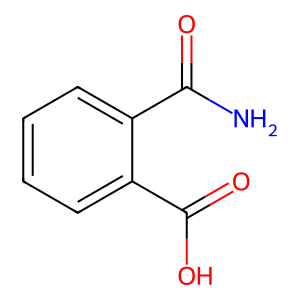

In [13]:
m = Chem.MolFromSmiles('OC(=O)c1ccccc1C(=O)N')
Draw.MolToImage(m)

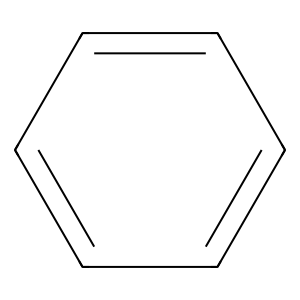

In [14]:
m = Chem.MolFromSmiles('c1ccccc1')
Draw.MolToImage(m)

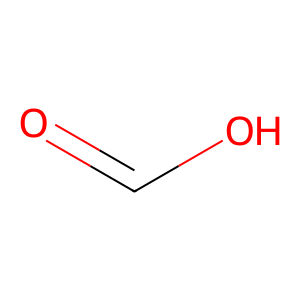

In [15]:
m = Chem.MolFromSmiles('OC(=O)')
Draw.MolToImage(m)

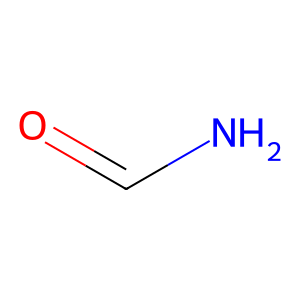

In [16]:
m = Chem.MolFromSmiles('C(=O)N')
Draw.MolToImage(m)

## Inference on a test SMILES dataset

Now, we show how model inference is performed on a test SMILES dataset.

Data is:

1. Loaded
2. Tokenized
3. Fed into the model to return the predicted docking score

In [ ]:
data_smiles = pd.read_csv('VirtualScreenTransformers/test_smiles.smi')

In [ ]:
data_smiles

,Smiles
0,Cc1c(snn1)C(=O)N2CCC[C@@H](C2)C(=O)c3cnn(c3N)c...
1,Cc1c(cccc1[N+](=O)[O-])C(=O)NC(=S)Nc2ccc(cc2)N...
2,Cc1c(scn1)C[NH+]2CCN(CC2)c3c4[nH+]cc(n4ccn3)c5...
3,C[C@@H](CN(C)C(=O)C1CCOCC1)C(=O)OC
4,Cc1c(sc(n1)NC(=O)c2c(noc2C)C)C
...,...
58,CCOc1cc(ccc1OCC(=O)NC2CCCCC2)C[NH2+]CCC[NH+]3C...
59,COCCC1(CCN(CC1)S(=O)(=O)c2cccnc2)c3nc(on3)c4cc...
60,Cc1cc(nn1C)C(=O)Nc2nc-3c(s2)COc4c3cccc4
61,COc1ccc(cc1C(=O)Nc2nc3cc(c(cc3s2)OC)Cl)Cl


In [ ]:
x_inference = preprocess(data_smiles['Smiles'],
                         tokenizer,
                         maxlen)

100%|██████████| 63/63 [00:00<00:00, 1343.76it/s]


In [ ]:
output = model.predict(x_inference, batch_size = 32)

2/2 [==============================] - 3s 1s/step


In [ ]:
print(output[:,0])

[[ 8.342318 ]
 [11.779715 ]
 [ 8.256606 ]
 [ 8.035853 ]
 [ 9.92575  ]
 [ 4.0407557]
 [ 8.754352 ]
 [ 7.5883183]
 [ 8.697096 ]
 [ 7.4068966]
 [ 9.015833 ]
 [ 9.891786 ]
 [ 7.1062407]
 [ 7.7503896]
 [ 8.051925 ]
 [ 8.6314535]
 [ 7.927847 ]
 [ 8.520679 ]
 [ 5.183228 ]
 [ 8.186373 ]
 [ 9.436341 ]
 [10.714754 ]
 [ 9.825087 ]
 [ 8.397918 ]
 [11.723889 ]
 [ 9.794795 ]
 [ 7.4901648]
 [ 6.989981 ]
 [ 8.61776  ]
 [ 8.007542 ]
 [ 8.91713  ]
 [ 9.998711 ]
 [ 9.205497 ]
 [ 9.800071 ]
 [ 7.233173 ]
 [ 7.0540104]
 [ 6.8479395]
 [ 6.4550567]
 [ 6.3660455]
 [ 5.5711637]
 [ 7.7704706]
 [ 9.717107 ]
 [10.325511 ]
 [ 8.332448 ]
 [10.226373 ]
 [ 5.498698 ]
 [ 9.671343 ]
 [ 8.467948 ]
 [ 9.588262 ]
 [10.223012 ]
 [ 5.4660754]
 [ 5.18373  ]
 [13.137334 ]
 [ 9.968843 ]
 [ 7.7357473]
 [ 9.56764  ]
 [11.352939 ]
 [ 8.731487 ]
 [ 6.7363925]
 [ 9.366592 ]
 [11.198803 ]
 [10.221776 ]
 [ 9.495995 ]]
